In [1]:
# !pip install phpserialize

In [2]:
import pandas as pd
import phpserialize
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
from scipy.interpolate import make_interp_spline, BSpline
import numpy as  np
import re
%matplotlib inline

In [3]:
data = pd.read_csv("select_timeid__cart_from_order_list_wher.csv",sep=";", header = None, names=['date','cart'])

In [4]:
# data.set_index("date", inplace=True)

In [5]:
data.head(5)

,date,cart
0,2017-12-31 23:31:04,"a:1:{s:10:""55081‡61"";a:16:{s:2:""id"";s:5:""55081..."
1,2017-12-31 23:08:22,"a:1:{s:27:""54857‡13"", Чер/жел1"";a:16:{s:2:""id""..."
2,2017-12-31 22:36:16,"a:1:{s:18:""53022‡67, P92 R1"";a:16:{s:2:""id"";s:..."
3,2017-12-31 21:48:40,"a:1:{s:13:""51980‡10.51"";a:16:{s:2:""id"";s:5:""51..."
4,2017-12-31 21:26:05,"a:1:{s:13:""51980‡10.51"";a:16:{s:2:""id"";s:5:""51..."


In [6]:
data['date'] =  pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')

In [7]:
# data['cart'][9]

In [8]:
def convert_php(x):
    try:
        return phpserialize.loads(x)
    except ValueError:
        return None

In [9]:
def convert_php_count(x):
    c = re.compile(r'^a\:(\d+)')
    find = c.search(x)
    if find:
        return find.group(1)
    else:
        return 0

In [10]:
def convert_php_sum_cart(x):
    c = re.compile(r's:\d+:\"price\";s:\d+:\"(\d+)\"')
    find = c.findall(x)
    if find:
        return np.array(find).astype(int).sum()
    else:
        return 0

In [11]:
def convert_php_export_items_price(x):
    c = re.compile(r's:\d+:\"price\";s:\d+:\"(\d+)\"')
    find = c.findall(x)
    if find:
        return np.array(find).astype(int)
    else:
        return np.array([])

In [12]:
# convert_php_sum_cart(data['cart'][9])

In [13]:
data.reset_index().loc[:3]

,index,date,cart
0,0,2017-12-31 23:31:04,"a:1:{s:10:""55081‡61"";a:16:{s:2:""id"";s:5:""55081..."
1,1,2017-12-31 23:08:22,"a:1:{s:27:""54857‡13"", Чер/жел1"";a:16:{s:2:""id""..."
2,2,2017-12-31 22:36:16,"a:1:{s:18:""53022‡67, P92 R1"";a:16:{s:2:""id"";s:..."
3,3,2017-12-31 21:48:40,"a:1:{s:13:""51980‡10.51"";a:16:{s:2:""id"";s:5:""51..."


In [14]:
test = data['cart'][:10].apply(lambda x: convert_php_export_items_price(x))

In [15]:
dict = {}
i=0
r = data.reset_index()
for index, row in r.iterrows():
    for val in convert_php_export_items_price(row['cart']):
        dict[i] = {'date': row['date'], 'item_cost': val}
        i+=1


In [16]:
new_date = pd.DataFrame.from_dict(dict, "index")

In [17]:
new_date = new_date.groupby(pd.Grouper(key='date', freq='W'))

In [18]:
new_date_median = new_date.median()
new_date_mean = new_date.mean()

In [19]:
data['count_item'] = data['cart'].apply(lambda x: convert_php_count(x))

In [20]:
data['cart_sum'] = data['cart'].apply(lambda x: convert_php_sum_cart(x))

In [21]:
data['count_item'] = data['count_item'].astype('float')

In [22]:
data_group = data.drop(columns=['cart'], axis=1).groupby(pd.Grouper(key='date', freq='W'))

In [23]:
result = data_group.median()

In [24]:
result_mean = data_group.mean()

In [25]:
# xnew = np.linspace(result['cart_sum'].min(),result['cart_sum'].max(),300)

In [26]:
# spl = make_interp_spline(result['cart_sum'].values, result.index.values, k=5) #BSpline object

In [27]:
# power_smooth = spl(result.index.values)

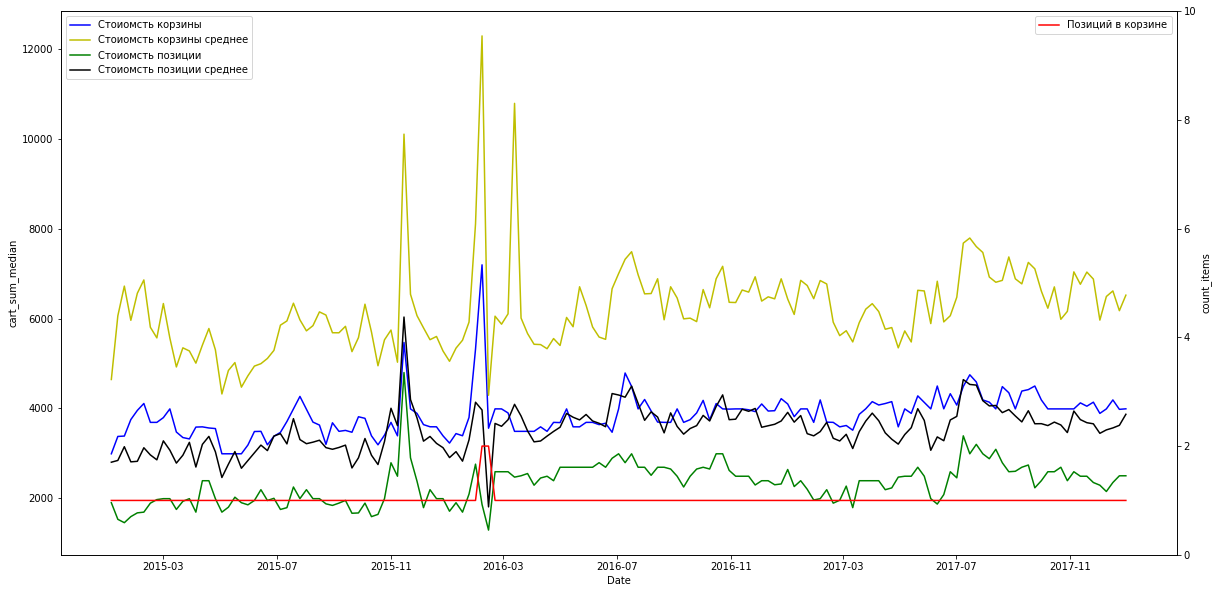

In [28]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1.twinx()
ax2.legend(loc=0)
ax2.set_ylim([0,10])
ax1.set_xlabel("Date")
ax1.set_ylabel("cart_sum_median")
ax2.set_ylabel("count_items")
ax2.plot(result['count_item'],"-r", label=u'Позиций в корзине')
ax1.plot(result['cart_sum'],"-b", label=u'Стоиомсть корзины')
ax1.plot(result_mean['cart_sum'],"-y", label=u'Стоиомсть корзины среднее')
ax1.plot(new_date_median['item_cost'],"-g", label=u'Стоиомсть позиции', antialiased=True)
ax1.plot(new_date_mean['item_cost'],"-k", label=u'Стоиомсть позиции среднее', antialiased=True)
# ax1.plot(result['non_reg'],linewidth=2)
ax2.legend(loc=1)
ax1.legend(loc=2)

In [29]:
# fig, ax1 = plt.subplots(figsize=(20,10))
# ax2 = ax1.twinx()
# ax2.plot(result['user']/result['count'],linestyle='solid',linewidth=4)
# ax2.set_ylim([0,1])
# ax2.legend([u'Динамика заказов зарегистрированных пользователей'])